In [1]:
import pandas as pd
import numpy as np
import nablachem.space as ncs
import random
from nablachem.space import algos

from sf_functions import *

# Step 1 
##### Create the chemical space with nablachem. The conditions must be the same as QM-9 incluides

In [2]:
# Define SearchSpace+

c = ncs.ApproximateCounter(show_progress=False)
s = ncs.SearchSpace("H:1 C:4 O:2 N:3 F:1")
selection = ncs.Q("C + O + N + F <= 9") 

sf_sum, size_sum = [], [] # Initialize empty lists to store results

for natoms in range(1, 30):  # 1..29
    random_order, sizes, stoichiometries = algos.chemical_formula_database(
        c, s, natoms, selection
        )
    sf_sum.extend(random_order)
    size_sum.extend(sizes)

print(f"Total unique formulas: {len(sf_sum)}")
print(f"Total estimated molecules: {sum(size_sum):.3e}")

Partition over valences: 100%|██████████| 4960/4960 [00:00<00:00, 22672.11it/s]

Total unique formulas: 2566
Total estimated molecules: 5.897e+07


reduce the space to the same conditions

In [3]:
# To follow the logic of the original code

filtered_sf = sf_sum 
filtered_sizes = size_sum

In [4]:
#display 10 random SMILES from the filtered list

random_sampling = random.sample(filtered_sf,10)
print(random_sampling)

['C3H6O4', 'HFN2O2', 'CHNO7', 'CH4FN5O2', 'C4H4N2', 'CH2N8', 'FN3O2', 'H5FN6O2', 'CH4N2O', 'H3NO6']


In [5]:
space_df = pd.DataFrame({
    "SF": filtered_sf,        
    "Frequency_space": filtered_sizes  
})

display(space_df)

,SF,Frequency_space
0,N2,1
1,C2,1
2,O2,1
3,H2,1
4,F2,1
...,...,...
2561,C9H18,338
2562,C7H18N2,688
2563,C8H18O,171
2564,C8H19N,211


In [6]:
#Counting the number of processed molecules

total_molecules_space = space_df["Frequency_space"].sum()
print(f"Number of processed molecules: {total_molecules_space}")

Number of processed molecules: 58972320


# Step 2
##### Upload the dataset of qm9

In [7]:
qm_df = pd.read_csv("QM9_sf_count.csv") #data already extracted and saved in a .csv file
display(qm_df)

,SF,frequency_QM9
0,C7H10O2,6094
1,C7H11NO,5858
2,C6H9NO2,5630
3,C7H9NO,5215
4,C8H12O,4918
...,...,...
611,C5N4,1
612,C6HN3,1
613,C2H5N3O2,1
614,C3H8N2O2,1


In [8]:
qm_df.rename(columns={"frequency_QM9":"Frequency_qm"}, inplace=True)
qm_df

,SF,Frequency_qm
0,C7H10O2,6094
1,C7H11NO,5858
2,C6H9NO2,5630
3,C7H9NO,5215
4,C8H12O,4918
...,...,...
611,C5N4,1
612,C6HN3,1
613,C2H5N3O2,1
614,C3H8N2O2,1


In [9]:
#Counting the number of processed molecules

total_molecules_qm = qm_df["Frequency_qm"].sum()
print(f"Number of processed molecules: {total_molecules_qm}")

Number of processed molecules: 130831


# Step 3
##### Merge the 2 dataset

In [10]:
#apply the function to order the SF in both datasets
space_df['SF'] = space_df['SF'].apply(ordered_SF)
qm_df['SF'] = qm_df['SF'].apply(ordered_SF)

In [11]:
merged_qm = pd.merge(space_df, qm_df, on='SF', how='outer' )
merged_qm  = merged_qm .fillna(0) #Filling na with 0

merged_qm ['Frequency_space'] = merged_qm ['Frequency_space'].astype('int64')
merged_qm ['Frequency_qm'] = merged_qm ['Frequency_qm'].astype('int64')

display(merged_qm )

,SF,Frequency_space,Frequency_qm
0,C2,1,0
1,C2F2,1,0
2,C2F2H2,2,0
3,C2F2H2N2,84,0
4,C2F2H2N2O,647,0
...,...,...,...
2561,O5,1,0
2562,O6,1,0
2563,O7,1,0
2564,O8,1,0


In [12]:
merged_qm.query("SF=='O9'")

,SF,Frequency_space,Frequency_qm
2565,O9,1,0


In [13]:
#Display  random values

merged_random = merged_qm.sample(20)
display(merged_random)

,SF,Frequency_space,Frequency_qm
2330,FH5N6O,419,0
6,C2F2H2N2O3,11416,0
659,C3FH8NO,87,0
1493,C6H12N2,10706,46
1509,C6H15N3,14947,0
483,C3F2H6,4,0
2425,H3N3O2,23,0
2119,CHN5,42,0
1653,C8FH,2879,0
1771,CF2N4O2,1097,0


In [14]:
print(f"The size of the QM9 database is: {total_molecules_qm}, and the size of the space is: {total_molecules_space}")

The size of the QM9 database is: 130831, and the size of the space is: 58972320


In [15]:
#Export the dataframe as a .csv file
merged_qm.to_csv("merged_qm_space.csv", index=False)

# Step 4
##### Plot and statistics

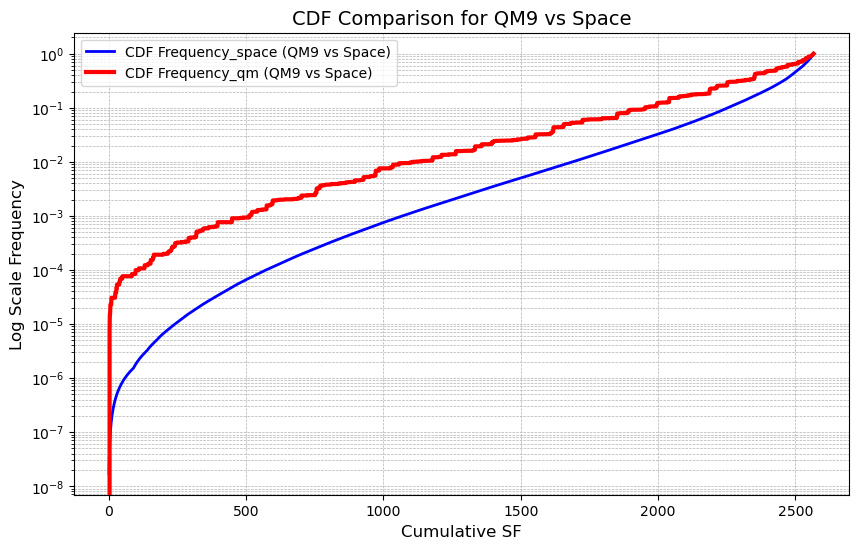

In [16]:
#1
plot_cdfs(data_frame=merged_qm, 
        distribution_one="Frequency_space", 
        distribution_two="Frequency_qm", 
        dataset_name="QM9 vs Space")

In [17]:
#2
metrics = calculate_metrics(merged_qm, "Frequency_space", "Frequency_qm")

Calculated Metrics:
                                            Metric       Value
                                      KS Statistic    0.484869
                       Area under Distribution One 1359.863940
                       Area under Distribution Two 1047.222322
                             Area between the CDFs  322.093338
Percentage Area Difference (relative to max curve)   23.685703
                            KL Divergence (P || Q)    5.140563


In [18]:
# Define sample franctions and n_bootstrap
sample_sizes_list = [0.001, 0.01, 0.1, 0.125, 0.15, 0.175, 0.2, 0.5, 0.8, 1.0]  # from 0,1% to 100%
n_bootstrap, alpha = 1000, 0.05

In [19]:
#3
confidence_intervals = bootstrap_metrics(merged_qm, 
                                        "Frequency_space",
                                        "Frequency_qm", 
                                        n_bootstrap, 
                                        alpha)

Metric    Value Confidence Interval
    KS 0.106841      [0.055, 0.185]
 KL_PQ 5.145883      [4.351, 6.003]


In [20]:
#4
random_results = random_sampling_subset(merged_qm, 
                                        "Frequency_space", 
                                        "Frequency_qm",
                                        sample_sizes_list, 
                                        n_bootstrap)


 Sample Fraction       KS    KL_PQ    KL_QP
           0.001 0.666667 1.138818 0.062111
           0.010 0.769231 5.291895 1.700137
           0.100 0.766537 6.386431 2.523813
           0.125 0.781931 6.236846 2.570407
           0.150 0.763636 6.359999 2.101446
           0.175 0.777283 6.237430 2.405290
           0.200 0.762183 7.058174 2.098415
           0.500 0.770070 5.622157 1.914599
           0.800 0.760351 5.296261 2.042779
           1.000 0.765004 5.140563 2.057425


In [21]:
display(metrics, confidence_intervals, random_results) #print all

,Metric,Value
0,KS Statistic,0.484869
1,Area under Distribution One,1359.863940
2,Area under Distribution Two,1047.222322
3,Area between the CDFs,322.093338
4,Percentage Area Difference (relative to max cu...,23.685703
5,KL Divergence (P || Q),5.140563


,Metric,Value,Confidence Interval
0,KS,0.106841,"[0.055, 0.185]"
1,KL_PQ,5.145883,"[4.351, 6.003]"


,Sample Fraction,KS,KL_PQ,KL_QP
0,0.001,0.666667,1.138818,0.062111
1,0.010,0.769231,5.291895,1.700137
2,0.100,0.766537,6.386431,2.523813
3,0.125,0.781931,6.236846,2.570407
4,0.150,0.763636,6.359999,2.101446
5,0.175,0.777283,6.237430,2.405290
6,0.200,0.762183,7.058174,2.098415
7,0.500,0.770070,5.622157,1.914599
8,0.800,0.760351,5.296261,2.042779
9,1.000,0.765004,5.140563,2.057425


In [22]:
calculate_relative_weights(merged_qm, "Frequency_space", "Frequency_qm")

,SF,Frequency_space,Frequency_qm,Weight_Frequency_space,Weight_Frequency_qm,Weight_combined
0,C2,1,0,1.695711e-08,0.0,1.691957e-08
1,C2F2,1,0,1.695711e-08,0.0,1.691957e-08
2,C2F2H2,2,0,3.391422e-08,0.0,3.383914e-08
3,C2F2H2N2,84,0,1.424397e-06,0.0,1.421244e-06
4,C2F2H2N2O,647,0,1.097125e-05,0.0,1.094696e-05
...,...,...,...,...,...,...
2561,O5,1,0,1.695711e-08,0.0,1.691957e-08
2562,O6,1,0,1.695711e-08,0.0,1.691957e-08
2563,O7,1,0,1.695711e-08,0.0,1.691957e-08
2564,O8,1,0,1.695711e-08,0.0,1.691957e-08


# Random Sampling 


#### Space vs Space subsets

In [23]:
# Normalise the frequency of each sum formula in the space
merged_qm["Space_weight"] = merged_qm["Frequency_space"] / merged_qm["Frequency_space"].sum()

merged_qm["qm_weight"] = merged_qm["Frequency_qm"] / merged_qm["Frequency_qm"].sum()
merged_qm

,SF,Frequency_space,Frequency_qm,Weight_Frequency_space,Weight_Frequency_qm,Weight_combined,Space_weight,qm_weight
0,C2,1,0,1.695711e-08,0.0,1.691957e-08,1.695711e-08,0.0
1,C2F2,1,0,1.695711e-08,0.0,1.691957e-08,1.695711e-08,0.0
2,C2F2H2,2,0,3.391422e-08,0.0,3.383914e-08,3.391422e-08,0.0
3,C2F2H2N2,84,0,1.424397e-06,0.0,1.421244e-06,1.424397e-06,0.0
4,C2F2H2N2O,647,0,1.097125e-05,0.0,1.094696e-05,1.097125e-05,0.0
...,...,...,...,...,...,...,...,...
2561,O5,1,0,1.695711e-08,0.0,1.691957e-08,1.695711e-08,0.0
2562,O6,1,0,1.695711e-08,0.0,1.691957e-08,1.695711e-08,0.0
2563,O7,1,0,1.695711e-08,0.0,1.691957e-08,1.695711e-08,0.0
2564,O8,1,0,1.695711e-08,0.0,1.691957e-08,1.695711e-08,0.0


In [24]:
# Inputs
sample_sizes_list = [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.015, 0.1, 0.5, 0.9, 1]
n_repeats = 100
alpha = 0.05

from scipy.stats import entropy  # Import to calculate KL divergence

# Total number of molecules already calculated
total_molecules = merged_qm['Frequency_space'].sum()
print(f"Total molecules = {total_molecules:,}")

# Results storage
results = []

for frac in sample_sizes_list:
    s_size = int(frac * total_molecules)
    if s_size < 1:
        s_size = 1
    ks_vals = []
    kl_vals = []
    for _ in range(n_repeats):
        # Random sampling based on Space_weight
        probabilities = merged_qm["Space_weight"].values / merged_qm["Space_weight"].sum()
        counts = np.random.multinomial(s_size, probabilities)
        df_sample = pd.DataFrame({
            'SF': merged_qm.index,
            'Selected_molecules': counts
        })

        # Calculate Space_weight for the subspace
        df_sample["Space_weight_sampled"] = df_sample["Selected_molecules"] / df_sample["Selected_molecules"].sum()

        # Normalize original Space_weight
        merged_qm["Space_weight_normalized"] = merged_qm["Space_weight"] / merged_qm["Space_weight"].sum()

        # Calculate KS
        ks_stat = np.max(np.abs(merged_qm["Space_weight_normalized"].cumsum() - df_sample["Space_weight_sampled"].cumsum()))
        KS = ks_stat
        ks_vals.append(KS)

        # Calculate KL divergence
        p = df_sample["Space_weight_sampled"]
        q = merged_qm["Space_weight_normalized"]
        KL_PQ = entropy(p, q)  # KL divergence
        kl_vals.append(KL_PQ)
    
    ks_mean = np.mean(ks_vals)
    kl_mean = np.mean(kl_vals)
    lower_p = 100 * (alpha / 2)
    upper_p = 100 * (1 - alpha / 2)
    ks_low, ks_up = np.percentile(ks_vals, [lower_p, upper_p])
    kl_low, kl_up = np.percentile(kl_vals, [lower_p, upper_p])
    
    results.append({
        "Sample Fraction": frac,
        "Sample Size": s_size,
        "KS_Mean": ks_mean,
        "KS_CI_95": f"[{ks_low:.4f}, {ks_up:.4f}]",
        "KL_PQ_Mean": kl_mean,
        "KL_PQ_CI_95": f"[{kl_low:.4f}, {kl_up:.4f}]"
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
display(results_df)

Total molecules = 58,972,320


,Sample Fraction,Sample Size,KS_Mean,KS_CI_95,KL_PQ_Mean,KL_PQ_CI_95
0,1.000000e-08,1,0.747878,"[0.5201, 0.9886]",5.796150,"[3.9501, 9.6177]"
1,1.000000e-07,5,0.360268,"[0.1834, 0.6422]",4.079483,"[2.9529, 5.5552]"
2,1.000000e-06,58,0.108667,"[0.0671, 0.1770]",1.868497,"[1.6531, 2.1720]"
3,1.000000e-05,589,0.035046,"[0.0210, 0.0530]",0.522396,"[0.4700, 0.5797]"
4,1.000000e-04,5897,0.010874,"[0.0057, 0.0177]",0.102228,"[0.0930, 0.1112]"
5,1.000000e-03,58972,0.003578,"[0.0018, 0.0060]",0.015486,"[0.0145, 0.0165]"
6,1.000000e-02,589723,0.001052,"[0.0006, 0.0017]",0.001966,"[0.0019, 0.0021]"
7,1.500000e-02,884584,0.000885,"[0.0005, 0.0014]",0.001334,"[0.0013, 0.0014]"
8,1.000000e-01,5897232,0.000362,"[0.0002, 0.0006]",0.000217,"[0.0002, 0.0002]"
9,5.000000e-01,29486160,0.000159,"[0.0001, 0.0003]",0.000044,"[0.0000, 0.0000]"


In [25]:
#Export the dataframe as a .csv file
results_df.to_csv("qm_1.csv", index=False)

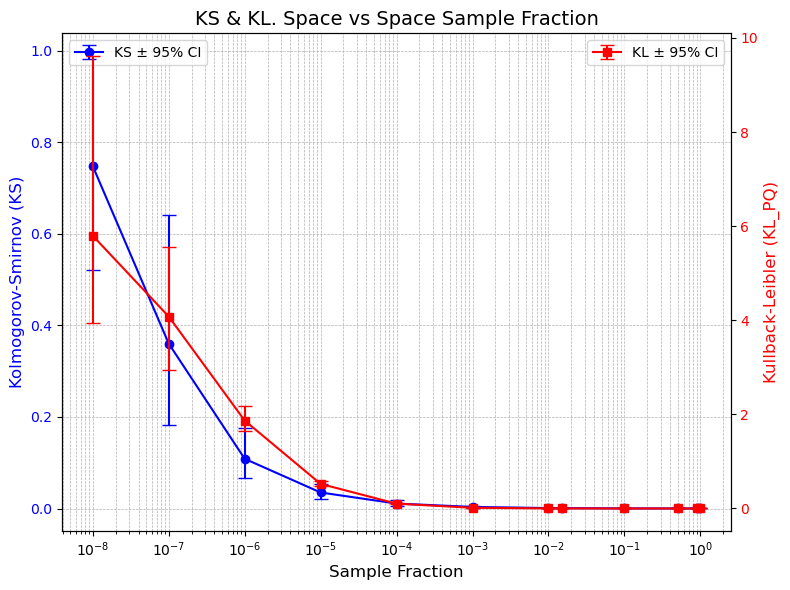

In [26]:
# Extract data
fractions = results_df["Sample Fraction"]

# KS Data
ks_means = results_df["KS_Mean"]
ks_cis = results_df["KS_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
ks_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(ks_means, ks_cis)]
ks_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(ks_means, ks_cis)]

# KL Data
kl_means = results_df["KL_PQ_Mean"]
kl_cis = results_df["KL_PQ_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
kl_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(kl_means, kl_cis)]
kl_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(kl_means, kl_cis)]

# Create figure and first Y-axis (KS)
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xscale("log")
ax1.set_xlabel("Sample Fraction", fontsize=12)
ax1.set_ylabel("Kolmogorov-Smirnov (KS)", color="blue", fontsize=12)
ax1.errorbar(fractions, ks_means, yerr=[ks_lower, ks_upper], fmt='o-', color="blue", capsize=5, label="KS ± 95% CI")
ax1.tick_params(axis='y', labelcolor="blue")

# Create second Y-axis (KL)
ax2 = ax1.twinx()
ax2.set_ylabel("Kullback-Leibler (KL_PQ)", color="red", fontsize=12)
ax2.errorbar(fractions, kl_means, yerr=[kl_lower, kl_upper], fmt='s-', color="red", capsize=5, label="KL ± 95% CI")
ax2.tick_params(axis='y', labelcolor="red")

# Title and Grid
plt.title("KS & KL. Space vs Space Sample Fraction", fontsize=14)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

## QM9 vs QM9 subsets

In [27]:
# Inputs
sample_sizes_list = [0.00001, 0.0001, 0.001, 0.01, 0.015, 0.1, 0.5, 0.9, 1]
n_repeats = 100
alpha = 0.05

from scipy.stats import entropy  # Import to calculate KL divergence

# Total number of molecules already calculated
total_molecules = merged_qm['Frequency_qm'].sum()
print(f"Total molecules = {total_molecules:,}")

# Results storage
results = []

for frac in sample_sizes_list:
    s_size = int(frac * total_molecules)
    if s_size < 1:
        s_size = 1
    ks_vals = []
    kl_vals = []
    for _ in range(n_repeats):
        # Random sampling based on qm_weight
        probabilities = merged_qm["qm_weight"].values / merged_qm["qm_weight"].sum()
        counts = np.random.multinomial(s_size, probabilities)
        df_sample = pd.DataFrame({
            'SF': merged_qm.index,
            'Selected_molecules': counts
        })

        # Calculate qm_weight for the subspace
        df_sample["qm_weight_sampled"] = df_sample["Selected_molecules"] / df_sample["Selected_molecules"].sum()

        # Normalize original qm_weight
        merged_qm["qm_weight_normalized"] = merged_qm["qm_weight"] / merged_qm["qm_weight"].sum()

        # Calculate KS
        ks_stat = np.max(np.abs(merged_qm["qm_weight_normalized"].cumsum() - df_sample["qm_weight_sampled"].cumsum()))
        KS = ks_stat
        ks_vals.append(KS)

        # Calculate KL divergence
        p = df_sample["qm_weight_sampled"]
        q = merged_qm["qm_weight_normalized"]
        KL_PQ = entropy(p, q)  # KL divergence
        kl_vals.append(KL_PQ)
    
    ks_mean = np.mean(ks_vals)
    kl_mean = np.mean(kl_vals)
    lower_p = 100 * (alpha / 2)
    upper_p = 100 * (1 - alpha / 2)
    ks_low, ks_up = np.percentile(ks_vals, [lower_p, upper_p])
    kl_low, kl_up = np.percentile(kl_vals, [lower_p, upper_p])
    
    results.append({
        "Sample Fraction": frac,
        "Sample Size": s_size,
        "KS_Mean": ks_mean,
        "KS_CI_95": f"[{ks_low:.4f}, {ks_up:.4f}]",
        "KL_PQ_Mean": kl_mean,
        "KL_PQ_CI_95": f"[{kl_low:.4f}, {kl_up:.4f}]"
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)

display(results_df)

Total molecules = 130,831


,Sample Fraction,Sample Size,KS_Mean,KS_CI_95,KL_PQ_Mean,KL_PQ_CI_95
0,0.00001,1,0.729465,"[0.4851, 0.9709]",4.500507,"[3.0666, 7.2705]"
1,0.00010,13,0.210067,"[0.1130, 0.3721]",2.092755,"[1.4654, 2.6750]"
2,0.00100,130,0.068971,"[0.0349, 0.1185]",0.675196,"[0.5314, 0.8034]"
3,0.01000,1308,0.022475,"[0.0113, 0.0440]",0.139572,"[0.1229, 0.1576]"
4,0.01500,1962,0.018938,"[0.0092, 0.0318]",0.102468,"[0.0910, 0.1150]"
5,0.10000,13083,0.007074,"[0.0038, 0.0143]",0.021825,"[0.0199, 0.0239]"
6,0.50000,65415,0.003078,"[0.0016, 0.0048]",0.004901,"[0.0045, 0.0054]"
7,0.90000,117747,0.002200,"[0.0012, 0.0039]",0.002752,"[0.0025, 0.0031]"
8,1.00000,130831,0.002153,"[0.0011, 0.0040]",0.002464,"[0.0023, 0.0027]"


In [28]:
#Export the dataframe as a .csv file
results_df.to_csv("qm_2.csv", index=False)

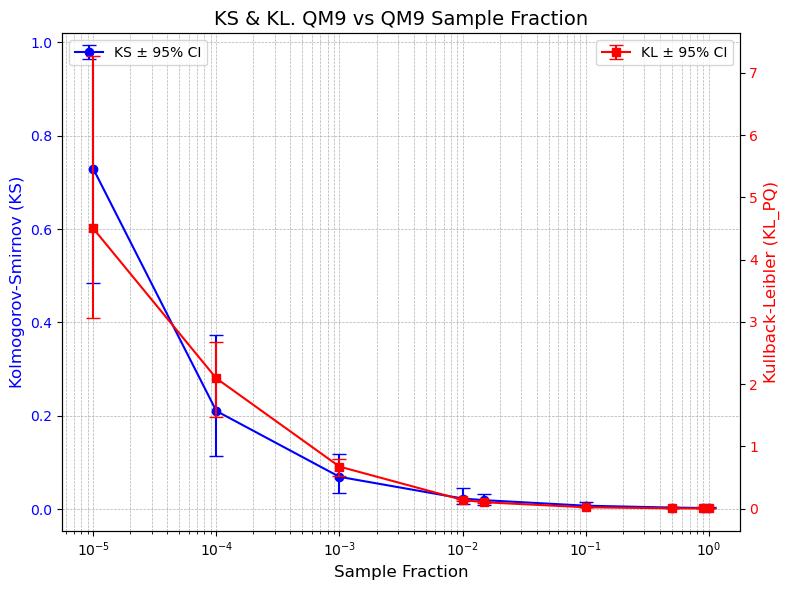

In [29]:
# Extract data
fractions = results_df["Sample Fraction"]

# KS Data
ks_means = results_df["KS_Mean"]
ks_cis = results_df["KS_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
ks_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(ks_means, ks_cis)]
ks_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(ks_means, ks_cis)]

# KL Data
kl_means = results_df["KL_PQ_Mean"]
kl_cis = results_df["KL_PQ_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
kl_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(kl_means, kl_cis)]
kl_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(kl_means, kl_cis)]

# Create figure and first Y-axis (KS)
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot KS
ax1.set_xscale("log")
ax1.set_xlabel("Sample Fraction", fontsize=12)
ax1.set_ylabel("Kolmogorov-Smirnov (KS)", color="blue", fontsize=12)
ax1.errorbar(fractions, ks_means, yerr=[ks_lower, ks_upper], fmt='o-', color="blue", capsize=5, label="KS ± 95% CI")
ax1.tick_params(axis='y', labelcolor="blue")

# Create second Y-axis (KL)
ax2 = ax1.twinx()
ax2.set_ylabel("Kullback-Leibler (KL_PQ)", color="red", fontsize=12)
ax2.errorbar(fractions, kl_means, yerr=[kl_lower, kl_upper], fmt='s-', color="red", capsize=5, label="KL ± 95% CI")
ax2.tick_params(axis='y', labelcolor="red")

# Title and Grid
plt.title("KS & KL. QM9 vs QM9 Sample Fraction", fontsize=14)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


# QM9 vs. Space sub sets

In [30]:
# Results storage
results = []

for frac in sample_sizes_list:
    s_size = int(frac * total_molecules_space)
    if s_size < 1:
        s_size = 1
    ks_vals = []
    kl_vals = []
    
    for _ in range(n_repeats):
        # Random sampling from Space
        probabilities_space = merged_qm["Frequency_space"].values / merged_qm["Frequency_space"].sum()
        counts_space = np.random.multinomial(s_size, probabilities_space)
        df_sample_space = pd.DataFrame({
            'SF': merged_qm.index,
            'Selected_molecules': counts_space
        })

        # Calculate sampled Space weights
        df_sample_space["space_weight_sampled"] = df_sample_space["Selected_molecules"] / df_sample_space["Selected_molecules"].sum()

        # Normalize QM weights
        merged_qm["qm_weight_normalized"] = merged_qm["Frequency_qm"] / merged_qm["Frequency_qm"].sum()

        # Add smoothing to avoid division by zero or log(0)
        df_sample_space["space_weight_sampled"] += 1e-10
        merged_qm["qm_weight_normalized"] += 1e-10

        # Calculate KS
        ks_stat = np.max(np.abs(
            merged_qm["qm_weight_normalized"].cumsum() - df_sample_space["space_weight_sampled"].cumsum()
        ))
        KS = ks_stat
        ks_vals.append(KS)

        # Calculate KL divergence
        p = df_sample_space["space_weight_sampled"]
        q = merged_qm["qm_weight_normalized"]
        KL_PQ = entropy(p, q)  # KL divergence
        kl_vals.append(KL_PQ)
    
    # Calculate statistics
    ks_mean = np.mean(ks_vals)
    kl_mean = np.mean(kl_vals)
    lower_p = 100 * (alpha / 2)
    upper_p = 100 * (1 - alpha / 2)
    ks_low, ks_up = np.percentile(ks_vals, [lower_p, upper_p])
    kl_low, kl_up = np.percentile(kl_vals, [lower_p, upper_p])
    
    results.append({
        "Sample Fraction": frac,
        "Sample Size": s_size,
        "KS_Mean": ks_mean,
        "KS_CI_95": f"[{ks_low:.4f}, {ks_up:.4f}]",
        "KL_PQ_Mean": kl_mean,
        "KL_PQ_CI_95": f"[{kl_low:.4f}, {kl_up:.4f}]"
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)

display(results_df)

,Sample Fraction,Sample Size,KS_Mean,KS_CI_95,KL_PQ_Mean,KL_PQ_CI_95
0,0.00001,589,0.487301,"[0.4488, 0.5218]",5.676025,"[5.1202, 6.2763]"
1,0.00010,5897,0.485506,"[0.4760, 0.4964]",5.246476,"[5.0694, 5.4243]"
2,0.00100,58972,0.484534,"[0.4812, 0.4879]",5.151255,"[5.0980, 5.2053]"
3,0.01000,589723,0.484822,"[0.4836, 0.4856]",5.141141,"[5.1249, 5.1579]"
4,0.01500,884584,0.484934,"[0.4840, 0.4860]",5.142279,"[5.1282, 5.1555]"
5,0.10000,5897232,0.484893,"[0.4845, 0.4853]",5.141108,"[5.1362, 5.1467]"
6,0.50000,29486160,0.484875,"[0.4847, 0.4850]",5.140570,"[5.1386, 5.1432]"
7,0.90000,53075088,0.484872,"[0.4848, 0.4850]",5.140657,"[5.1389, 5.1422]"
8,1.00000,58972320,0.484861,"[0.4848, 0.4850]",5.140633,"[5.1387, 5.1426]"


In [31]:
#Export the dataframe as a .csv file
results_df.to_csv("qm_3.csv", index=False)

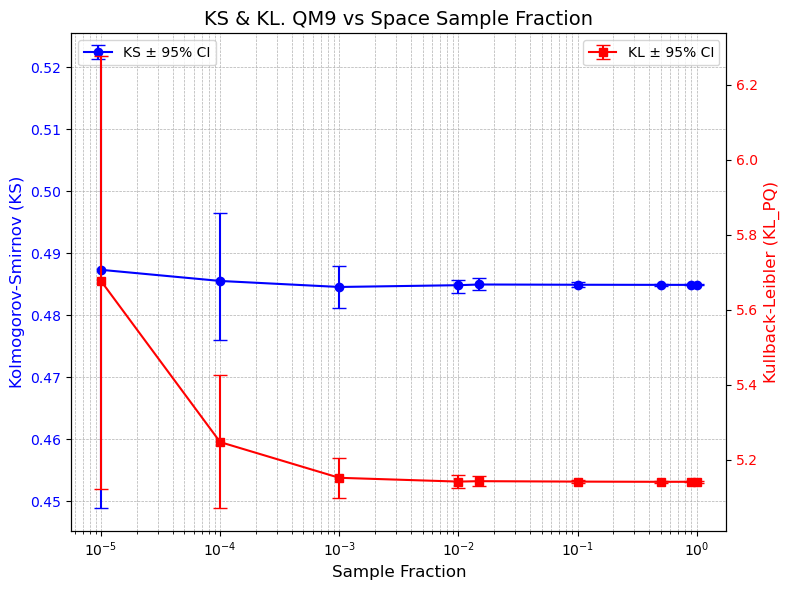

In [ ]:
# Extract data
fractions = results_df["Sample Fraction"]

# KS Data
ks_means = results_df["KS_Mean"]
ks_cis = results_df["KS_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
ks_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(ks_means, ks_cis)]
ks_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(ks_means, ks_cis)]

# KL Data
kl_means = results_df["KL_PQ_Mean"]
kl_cis = results_df["KL_PQ_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
kl_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(kl_means, kl_cis)]
kl_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(kl_means, kl_cis)]

# Create figure and first Y-axis (KS)
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot KS
ax1.set_xscale("log")
ax1.set_xlabel("Sample Fraction", fontsize=12)
ax1.set_ylabel("Kolmogorov-Smirnov (KS)", color="blue", fontsize=12)
ax1.errorbar(fractions, ks_means, yerr=[ks_lower, ks_upper], fmt='o-', color="blue", capsize=5, label="KS ± 95% CI")
ax1.tick_params(axis='y', labelcolor="blue")

# Create second Y-axis (KL)
ax2 = ax1.twinx()
ax2.set_ylabel("Kullback-Leibler (KL_PQ)", color="red", fontsize=12)
ax2.errorbar(fractions, kl_means, yerr=[kl_lower, kl_upper], fmt='s-', color="red", capsize=5, label="KL ± 95% CI")
ax2.tick_params(axis='y', labelcolor="red")

# Title and Grid
plt.title("KS & KL. QM9 vs Space Sample Fraction", fontsize=14)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

# Chemical Space vs QM-9 Sample Fraction

In [33]:
sample_sizes_list = [1e-5, 0.0001, 0.001, 0.01, 0.1, 1]  # only base 10
results = []

for frac in sample_sizes_list:
    s_size = int(frac * total_molecules_qm)
    ks_vals = []
    kl_vals = []

    for _ in range(n_repeats):
        # 1. Sampling from QM9
        probabilities = merged_qm["Frequency_qm"].values / merged_qm["Frequency_qm"].sum()
        counts = np.random.multinomial(s_size, probabilities)
        df_sample = pd.DataFrame({
            'SF': merged_qm.index,
            'Selected_molecules': counts
        })

        df_sample["qm_weight_sampled"] = df_sample["Selected_molecules"] / df_sample["Selected_molecules"].sum()

        # 2. Reference: Chemical Space
        merged_qm["space_weight_normalized"] = merged_qm["Frequency_space"] / merged_qm["Frequency_space"].sum()

        # 3. Numerical smoothing (prevent KL log(0))
        df_sample["qm_weight_sampled"] += 1e-10
        merged_qm["space_weight_normalized"] += 1e-10

        # 4. Kolmogorov–Smirnov
        ks_stat = np.max(np.abs(
            merged_qm["space_weight_normalized"].cumsum() - df_sample["qm_weight_sampled"].cumsum()
        ))
        ks_vals.append(ks_stat)

        # 5. Kullback–Leibler divergence
        p = df_sample["qm_weight_sampled"]
        q = merged_qm["space_weight_normalized"]
        KL_PQ = entropy(p, q)
        kl_vals.append(KL_PQ)

    # Final statistics
    ks_mean = np.mean(ks_vals)
    kl_mean = np.mean(kl_vals)
    lower_p = 100 * (alpha / 2)
    upper_p = 100 * (1 - alpha / 2)
    ks_low, ks_up = np.percentile(ks_vals, [lower_p, upper_p])
    kl_low, kl_up = np.percentile(kl_vals, [lower_p, upper_p])

    results.append({
        "Sample Fraction": frac,
        "Sample Size": s_size,
        "KS_Mean": ks_mean,
        "KS_CI_95": f"[{ks_low:.4f}, {ks_up:.4f}]",
        "KL_PQ_Mean": kl_mean,
        "KL_PQ_CI_95": f"[{kl_low:.4f}, {kl_up:.4f}]"
    })

results_df = pd.DataFrame(results)
display(results_df)

,Sample Fraction,Sample Size,KS_Mean,KS_CI_95,KL_PQ_Mean,KL_PQ_CI_95
0,0.00001,1,0.814331,"[0.5669, 0.9815]",6.501557,"[4.2013, 11.1298]"
1,0.00010,13,0.569894,"[0.4083, 0.7229]",4.227241,"[3.3857, 5.3865]"
2,0.00100,130,0.487517,"[0.4276, 0.5473]",2.732580,"[2.4408, 2.9712]"
3,0.01000,1308,0.486165,"[0.4641, 0.5054]",2.202618,"[2.1193, 2.3135]"
4,0.10000,13083,0.485415,"[0.4785, 0.4914]",2.077263,"[2.0489, 2.1092]"
5,1.00000,130831,0.484853,"[0.4828, 0.4868]",2.059379,"[2.0504, 2.0695]"


In [34]:
#Export the dataframe as a .csv file
results_df.to_csv("qm_4.csv", index=False)

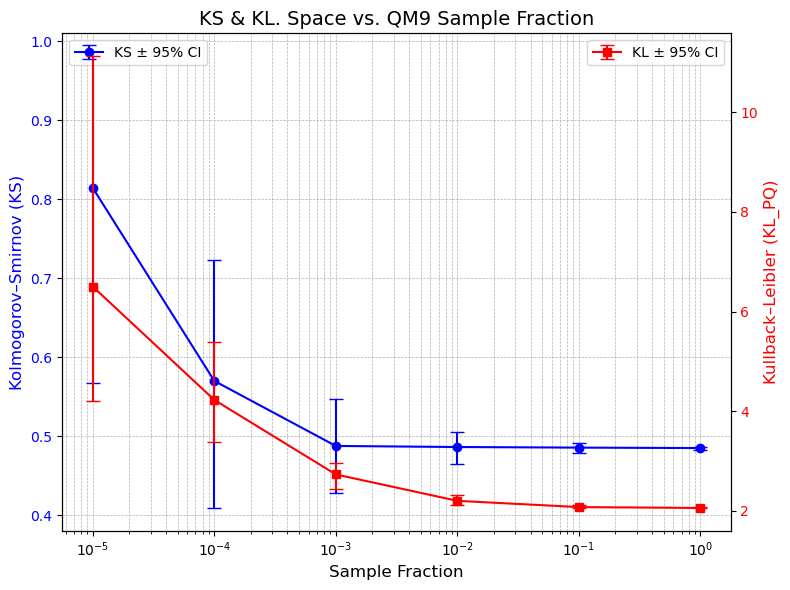

In [35]:
# Extract data  
fractions = results_df["Sample Fraction"]

# KS
ks_means = results_df["KS_Mean"]
ks_cis = results_df["KS_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
ks_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(ks_means, ks_cis)]
ks_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(ks_means, ks_cis)]

# KL
kl_means = results_df["KL_PQ_Mean"]
kl_cis = results_df["KL_PQ_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
kl_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(kl_means, kl_cis)]
kl_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(kl_means, kl_cis)]

#Create figure nd first Y-axis (KS)
fig, ax1 = plt.subplots(figsize=(8, 6))

# KS plot
ax1.set_xscale("log")
ax1.set_xlabel("Sample Fraction", fontsize=12)
ax1.set_ylabel("Kolmogorov–Smirnov (KS)", color="blue", fontsize=12)
ax1.errorbar(fractions, ks_means, yerr=[ks_lower, ks_upper],
             fmt='o-', color="blue", capsize=5, label="KS ± 95% CI")
ax1.tick_params(axis='y', labelcolor="blue")

# KL plot
ax2 = ax1.twinx()
ax2.set_ylabel("Kullback–Leibler (KL_PQ)", color="red", fontsize=12)
ax2.errorbar(fractions, kl_means, yerr=[kl_lower, kl_upper],
             fmt='s-', color="red", capsize=5, label="KL ± 95% CI")
ax2.tick_params(axis='y', labelcolor="red")

plt.title("KS & KL. Space vs. QM9 Sample Fraction", fontsize=14)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()